<a href="https://colab.research.google.com/github/MANicholson/Figures-Modelling-and-Simulation-of-a-CMOS-Synapse-Implementing-Two-phase-Plasticity/blob/main/Figure_9_and_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports and installs**

In [ ]:
!pip install equinox

# Imports
import jax
import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.1 MB/s eta 0:00:00


# **Differential equations**

In [ ]:
class full_synapse_diff(eqx.Module):
    # Calcium constants --------------------------------------------------------
    c_pre: float
    c_post: float
    tau_c: float
    dt: float
    c_0: float
    # Early-phase constants ----------------------------------------------------
    tau_h: float
    h_max: float
    gamma_p: float
    gamma_d: float
    theta_p: float
    theta_d: float
    h_0: float
    h_init: float
    # Late-phase constants -----------------------------------------------------
    tau_z: float
    z_max: float
    z_min: float
    theta_tag: float
    alpha: float
    theta_pro: float
    z_0: float

    def __init__(self, c_pre, c_post, tau_c, dt, c_0, tau_h, h_max, gamma_p, gamma_d, theta_p, theta_d, h_0, h_init, tau_z, z_max, z_min, theta_tag, alpha, theta_pro, z_0):
        # Calcium constants ----------------------------------------------------
        self.c_pre = c_pre
        self.c_post = c_post
        self.tau_c = tau_c
        self.dt = dt
        self.c_0 = c_0
        # Early-phase constants ------------------------------------------------
        self.tau_h = tau_h
        self.h_max = h_max
        self.gamma_p = gamma_p
        self.gamma_d = gamma_d
        self.theta_p = theta_p
        self.theta_d = theta_d
        self.h_0 = h_0
        self.h_init = h_init
        # Late-phase constants -------------------------------------------------
        self.tau_z = tau_z
        self.z_max = z_max
        self.z_min = z_min
        self.theta_tag = theta_tag
        self.alpha = alpha
        self.theta_pro = theta_pro
        self.z_0 = z_0

    def __call__(self, input_):

        # Calcium part ---------------------------------------------------------
        c_ji_0 = jnp.zeros((1,)) + self.c_0  # Initial state

        def differential_eq_calcium(c_ji, input_):
            t_spike_pre, t_spike_post = input_

            dc_dt = -c_ji / self.tau_c
            c_pre_increase = t_spike_pre * self.c_pre
            c_post_increase = t_spike_post * self.c_post

            c_ji_new = c_ji + dc_dt * self.dt + c_pre_increase + c_post_increase

            return c_ji_new, c_ji_new

        _, c_ji = jax.lax.scan(differential_eq_calcium, c_ji_0, input_)

        time_array = jnp.arange(len(c_ji)) * self.dt

        # Early-phase part -----------------------------------------------------
        if self.h_init is None:
            self.h_init = self.h_0

        h_ji_0 = jnp.zeros((1,)) + self.h_init

        def differential_eq_early_phase(h_ji, c_ji):
            # Early-phase weight decay:
            decay_term = (1 / self.tau_h) * 0.1 * (self.h_0 - h_ji)

            # Early-phase LTP (potentiation occurs when the calcium concentration surpasses the specified threshold)
            ltp_term = (1 / self.tau_h) * self.gamma_p * (self.h_max - h_ji) * (c_ji > self.theta_p)

            # Early-phase LTD (depression occurs when the calcium concentration surpasses the specified threshold)
            ltd_term = (1 / self.tau_h) * self.gamma_d * h_ji * (c_ji > self.theta_d)

            # Combine terms
            dh_dt = decay_term + ltp_term - ltd_term

            # Update the early-phase variable using Euler's method
            h_ji_new = h_ji + dh_dt * self.dt

            return h_ji_new, h_ji_new

        _, h_ji = jax.lax.scan(differential_eq_early_phase, h_ji_0, c_ji)

        # Late-phase part ------------------------------------------------------
        z_ji_0 = jnp.zeros((1,)) + self.z_0

        # Set the protein availability to 0:
        p_i = 0.0

        def differential_eq_late_phase(carry, input_):
            z_ji, p_i = carry
            h_ji, c_ji = input_

            # Early-phase change of neuron i
            epsilon_hi = jnp.abs(h_ji - self.h_0)

            # Check if the early-phase change is sufficient to trigger protein synthesis:
            condition = jnp.squeeze(epsilon_hi > self.theta_pro)
            p_i = jax.lax.cond(condition, lambda _: self.alpha, lambda _: p_i, operand=None)

            # Calculate the change in late-phase variable based on the differential equation.

            # Potentiation contribution
            pot_term = p_i * (self.z_max - z_ji) * ((h_ji - self.h_0 - self.theta_tag) > 0)

            # Depression contribution
            dep_term = p_i * (z_ji - self.z_min) * ((self.h_0 - h_ji - self.theta_tag) > 0)

            # Combine terms to get the total change
            dz_dt = (1 / self.tau_z) * (pot_term - dep_term)

            # Update late-phase variable using Euler's method
            z_ji_new = z_ji + dz_dt * self.dt

            return (z_ji_new, p_i), z_ji_new

        carry = (z_ji_0, p_i)
        inputs = (h_ji, c_ji)
        _, z_ji = jax.lax.scan(differential_eq_late_phase, carry, inputs)

        # Calculate the total synaptic weight ----------------------------------

        w_ji_0 = jnp.zeros((1,)) + h_ji_0 + h_ji_0 * z_ji_0


        def total_synaptic_weight(w_ji, Inputs_):
            h_ji, z_ji = Inputs_

            w_ji_new = h_ji + h_ji_0 * z_ji

            return w_ji_new, w_ji_new


        Inputs_ = (h_ji, z_ji)
        _, w_ji = jax.lax.scan(total_synaptic_weight, w_ji_0, Inputs_)

        return c_ji, h_ji, z_ji, w_ji, time_array


# **Circuits**

In [ ]:
class full_synapse_ciruit(eqx.Module):
    tau_DPI: float
    dt: float
    delta_capre: float
    delta_capost: float
    I_TH: float
    I_INDC: float
    I_TAU: float
    ica_0: float
    C: float
    v_H0: float
    I_THPOT: float
    I_THDEP: float
    I_TAILP: float
    I_TAILP_low: float
    I_TAILD: float
    I_TAILD_low: float
    i_hrn: float
    i_hrp: float
    v_h0: float
    V_DD: float
    tau_z_c: float
    z_max: float
    z_min: float
    theta_tag_c: float
    alpha: float
    theta_pro_circuit: float
    z_0: float
    beta: float
    h_0: float = 0.0

    def __call__(self, input_):
        # Calcium part ---------------------------------------------------------
        i_ca_0 = jnp.zeros((1,)) + self.ica_0  # Initial state

        def calcium_circuit(i_ca, input_):
            t_spike_pre, t_spike_post = input_

            dica_dt = (1 / self.tau_DPI) * (-i_ca + self.I_TH * self.I_INDC / self.I_TAU)
            ica_pre_increase = t_spike_pre * self.delta_capre
            ica_post_increase = t_spike_post * self.delta_capost

            i_ca_new = i_ca + dica_dt * self.dt + ica_pre_increase + ica_post_increase

            return i_ca_new, i_ca_new

        _, i_ca = jax.lax.scan(calcium_circuit, i_ca_0, input_)

        time_array = jnp.arange(len(i_ca)) * self.dt

        # Early-phase part -----------------------------------------------------
        v_h_0 = jnp.zeros((1,)) + self.v_h0

        integrand = jnp.zeros((1,))

        def early_phase_circuit_loop(v_h, i_ca):
            # Calculate recovery current
            recovery_condition = jnp.squeeze(v_h > self.v_H0)
            potentiation_condition = jnp.squeeze(i_ca > self.I_THPOT)
            depression_condition = jnp.squeeze(i_ca > self.I_THDEP)

            i_recovery = jax.lax.cond(recovery_condition, lambda _: - self.i_hrn, lambda _: self.i_hrp, operand=None)
            i_potentiation = jax.lax.cond(potentiation_condition, lambda _: self.I_TAILP, lambda _: self.I_TAILP_low, operand=None)
            i_depression = jax.lax.cond(depression_condition, lambda _: - self.I_TAILD, lambda _: self.I_TAILD_low, operand=None)

            # Update current_sum
            v_h_new = v_h + (1 / self.C) * (i_recovery + i_potentiation + i_depression) * self.dt

            return v_h_new, v_h_new

        _, v_h = jax.lax.scan(early_phase_circuit_loop, v_h_0, i_ca)

        # Late-phase part ------------------------------------------------------
        z_ji_0 = jnp.zeros((1,)) + self.z_0

        # Set the protein availability to 0:
        p_i = 0.0

        def differential_eq_late_phase(carry, input_):
            z_ji, p_i = carry
            v_h, i_ca = input_

            # Early-phase change of neuron i
            epsilon_hi = jnp.abs(v_h - self.v_h0)

            # Check if the early-phase change is sufficient to trigger protein synthesis:
            condition = jnp.squeeze(epsilon_hi > self.theta_pro_circuit)
            p_i = jax.lax.cond(condition, lambda _: self.alpha, lambda _: p_i, operand=None)


            # Calculate the change in late-phase variable based on the differential equation.

            # Potentiation contribution
            pot_term = p_i * (self.z_max - z_ji) * ((v_h - self.v_h0 - self.theta_tag_c) > 0)

            # Depression contribution
            dep_term = p_i * (z_ji - self.z_min) * ((self.h_0 - v_h - self.theta_tag_c) > 0)

            # Combine terms to get the total change
            dz_dt = (1 / self.tau_z_c) * (pot_term - dep_term)

            # Update late-phase variable using Euler's method
            z_ji_new = z_ji + dz_dt * self.dt

            return (z_ji_new, p_i), z_ji_new

        carry = (z_ji_0, p_i)
        inputs = (v_h, i_ca)
        _, z_ji = jax.lax.scan(differential_eq_late_phase, carry, inputs)

        # Calculate the total synaptic weight ----------------------------------

        w_ji_0 = jnp.zeros((1,)) + 5.6675*10**(-3) * v_h0 + 5.6675*10**(-3) * self.v_h0 * z_ji_0

        def total_synaptic_weight(w_ji, Inputs_):
            v_h, z_ji = Inputs_

            w_ji_new = 5.6675*10**(-3) * v_h + 5.6675*10**(-3) * self.v_h0 * z_ji

            return w_ji_new, w_ji_new


        Inputs_ = (v_h, z_ji)
        _, w_ji = jax.lax.scan(total_synaptic_weight, w_ji_0, Inputs_)


        return i_ca, v_h, z_ji, w_ji, time_array



# **Testing**

## Defining constants (for the differential equation code)

In [ ]:
# Constants

# tc_delay = 0.0188  # Delay of postsynaptic calcium influx after presynaptic spike [s]
c_pre = 0.6  # Presynaptic calcium contribution [in vivo adjusted]
c_post = 0.1655  # Postsynaptic calcium contribution [in vivo adjusted]
tau_c = 0.0488  # Calcium time constant [s]
tau_h = 688.4 # ALTERED FROM 688.4  # Early-phase time constant [s]
tau_p = 60*60  # Protein time constant [s]
tau_z = 60*60  # Late-phase time constant [s]
# nu_th = 40  # Firing rate threshold for LTP induction [Hz]
gamma_p = 1645.6 # ALTERED FROM 1645.6  # Potentiation rate
gamma_d = 313.1 # ALTERED FROM 313.1  # Depression rate
theta_p = 0.3 # ALTERED FROM 3  # Calcium threshold for potentiation
theta_d = 0.2 # ALTERED FROM 1.2  # Calcium threshold for depression
# sigma_pl = 2.90436 * 10**(-3)  # Standard deviation for plasticity fluctuations [V]
alpha = 1.0  # Protein synthesis rate
theta_pro = 0.0023 #2.10037  * 10**(-3)  # Protein synthesis threshold [V]
theta_tag = 0.640149  * 10**(-4)  # Tagging threshold [V]
h_0 = 4.20075  * 10**(-3) # Median initial excitatory→excitatory coupling strength [V]
h_init = h_0
z_0 = 0.1
# Combining Jorge's thesis and Jannik's paper

h_max = 10 * 10**(-3) # The maximum value of the early-phase variable [V]
z_max = 1 # The minimum value of the late-phase variable
z_min = - 0.5 # The maximum value of the late-phase variable

# beta = 4.6675*10**(-3)

## Defining constants (for the circuit code)

In [ ]:
# Calcium:
I_INDC = 25 * 10**(-12)
i_pre = 800 * 10**(-12)
i_post = 200 * 10**(-12)
tau_DPI = 0.00488 # 4.88 * 10**(-3) <--- This works for a dt of 0.001
I_TH = 10 * 10**(-12)
I_TAU = 20 * 10**(-12)
ica_0 = 17 * 10**(-12)
delta_capre = 60 * 10**(-12)
delta_capost = 15 * 10**(-12)


# Early-phase:
tau_h_c = 68.84 # [s]
C = 1.2215 * 10**(-12)
v_H0 = 0.9 # [V] V_H0 = 1/2 * V_DD (page 30 Jorge)
I_THPOT = 62 * 10**(-12) # 62
I_THDEP = 55 * 10**(-12) # 39.5
I_TAILP = 90 * 10**(-12)
I_TAILP_low = 1.2 * 10**(-15) #<----------------------------------------
I_TAILD = 10 * 10**(-12)
I_TAILD_low = 0.8 * 10**(-15) #<----------------------------------------
i_hrp = 2.5 * 10**(-15)
i_hrn = 2.5 * 10**(-15)
v_h0 = 900 * 10**(-3) # [V]
V_DD = 1.8 # [V]
z_0 = 0.1
# Late phase:
theta_tag_c = 0.0151226
theta_pro_circuit = 0.45
tau_z_c = 360
tau_p_c = 360


beta = 4.6675*10**(-3) # The constant needed to convvert the early-phase voltage given by Jorge's circuit to voltages comparable with Jannik's paper (and the late phase weight).

## Test input

### Test input generator

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as random

def generate_binary_array(length, ratio, key):
    """
    Generate a binary array of 0s and 1s with a specific ratio of 1s to 0s.

    Args:
        length (int): Length of the array.
        ratio (float): Desired ratio of 1s to 0s.
        key (jax.random.PRNGKey): Random key for JAX's random number generator.

    Returns:
        jax.numpy.ndarray: Array of 0s and 1s with the specified ratio.
    """
    num_ones = int(length * ratio)
    num_zeros = length - num_ones

    # Create an array with the specified number of 1s and 0s
    binary_array = jnp.array([1] * num_ones + [0] * num_zeros)

    # Shuffle the array to randomize the distribution of 1s and 0s
    shuffled_array = random.permutation(key, binary_array)

    return shuffled_array

# Example usage
key = random.PRNGKey(0)
length = 1000  # Length of the array
ratio = 0.1   # Desired ratio of 1s to 0s

pre_spikes =  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] #generate_binary_array(length, ratio, key)

post_spikes = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0] #generate_binary_array(length, ratio, key)



In [ ]:
# Add 300 zeros to the end of the array
post_spikes.extend([0] * 300)
pre_spikes.extend([0] * 300)

print(post_spikes)
print(pre_spikes)
print(f"Length of post_spikes: {len(post_spikes)}")

t_array = jnp.linspace(0, 10000, len(pre_spikes))
dt = 0.01

t_array_c = jnp.linspace(0, 1000, len(pre_spikes))
dt_c = 0.001


[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Initialize time array and concentration array.
t_max = t_array[-1]
t = jnp.arange(0, t_max + dt, dt)

# Map presynaptic spike times onto new t array to ensure the spikes on a multiple of dt
t_spike_pre_new = jnp.zeros_like(t)
for i, time_point in enumerate(t_array):
    # Find the index of the closest time point in 't'
    closest_idx = jnp.argmin(jnp.abs(t - time_point))
    # Assign the value from 'i_in' to the corresponding location in 'i_new'
    t_spike_pre_new = t_spike_pre_new.at[closest_idx].set(pre_spikes[i])


# Map postsynaptic spike times onto new t array to ensure the spikes on a multiple of dt
t_spike_post_new = jnp.zeros_like(t)
for i, time_point in enumerate(t_array):
    # Find the index of the closest time point in 't'
    closest_idx = jnp.argmin(jnp.abs(t - time_point))
    # Assign the value from 'i_in' to the corresponding location in 'i_new'
    t_spike_post_new = t_spike_post_new.at[closest_idx].set(post_spikes[i])

In [ ]:
# Initialize time array and concentration array.
t_max_c = t_array_c[-1]
t_c = jnp.arange(0, t_max_c + dt_c, dt_c)

# Map presynaptic spike times onto new t array to ensure the spikes on a multiple of dt
t_spike_pre_new_c = jnp.zeros_like(t_c)
for i, time_point in enumerate(t_array_c):
    # Find the index of the closest time point in 't'
    closest_idx_c = jnp.argmin(jnp.abs(t_c - time_point))
    # Assign the value from 'i_in' to the corresponding location in 'i_new'
    t_spike_pre_new_c = t_spike_pre_new_c.at[closest_idx_c].set(pre_spikes[i])

# Map postsynaptic spike times onto new t array to ensure the spikes on a multiple of dt
t_spike_post_new_c = jnp.zeros_like(t_c)
for i, time_point in enumerate(t_array_c):
    # Find the index of the closest time point in 't'
    closest_idx_c = jnp.argmin(jnp.abs(t_c - time_point))
    # Assign the value from 'i_in' to the corresponding location in 'i_new'
    t_spike_post_new_c = t_spike_post_new_c.at[closest_idx_c].set(post_spikes[i])

In [ ]:
synapseModel = full_synapse_diff(c_pre, c_post, tau_c, dt, 0, tau_h, h_max, gamma_p, gamma_d, theta_p, theta_d, h_0, h_init, tau_z, z_max, z_min, theta_tag, alpha, theta_pro, z_0)

c_ji_eqx, h_ji_eqx, z_ji_eqx, w_ji_eqx, t_eqx = synapseModel((jnp.array(t_spike_pre_new), jnp.array(t_spike_post_new)))

## Plotting the results

### Differential

### Circuit

In [ ]:
synapseCircuit = full_synapse_ciruit(
    tau_DPI, dt_c, delta_capre, delta_capost, I_TH, I_INDC, I_TAU, ica_0,
    C, v_H0, I_THPOT, I_THDEP, I_TAILP, I_TAILP_low, I_TAILD, I_TAILD_low, i_hrn, i_hrp,
    v_h0, V_DD, tau_z_c, z_max, z_min, theta_tag_c, alpha, theta_pro_circuit, z_0, beta
)
c_ji_eqx_c, h_ji_eqx_c, z_ji_eqx_c, w_ji_eqx_c, t_eqx_c = synapseCircuit((jnp.array(t_spike_pre_new_c), jnp.array(t_spike_post_new_c)))



### Side by side

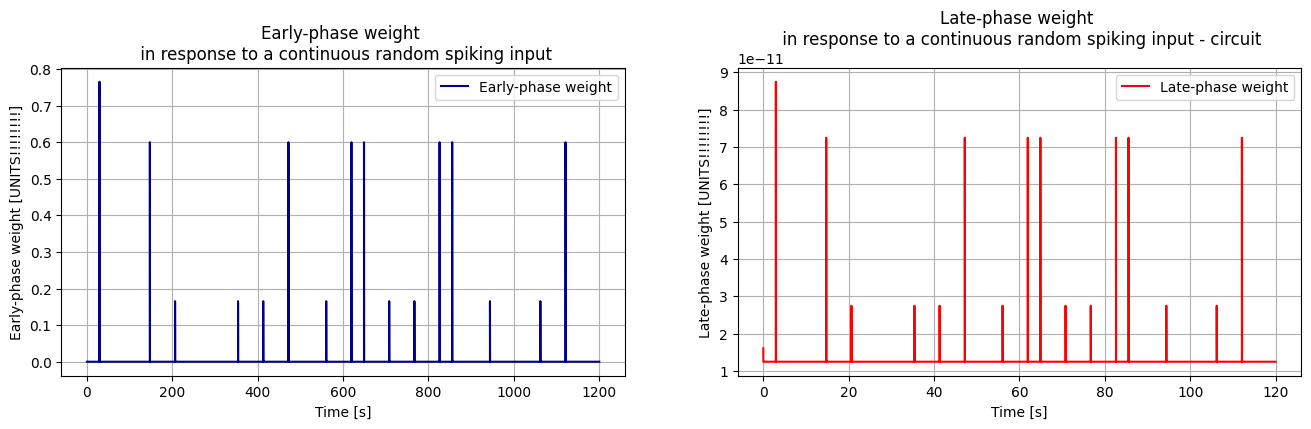

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 4))



# Plot first set of subplots
#axes[0].plot(t_eqx[9375:9425], c_ji_eqx[9375:9425], color='darkblue', label='Early-phase weight')
axes[0].plot(t_eqx[:120000], c_ji_eqx[:120000], color='darkblue', label='Early-phase weight')
axes[0].set_title("Early-phase weight \n in response to a continuous random spiking input")
axes[0].legend()
axes[0].grid()
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Early-phase weight [UNITS!!!!!!!!]")

#axes[1].plot(t_eqx_c[9375:9425], c_ji_eqx_c[9375:9425], color='red', label='Late-phase weight')
axes[1].plot(t_eqx_c[:120000], c_ji_eqx_c[:120000], color='red', label='Late-phase weight')
#axes[1].plot(t_eqx_c, c_ji_eqx_c, color='red', label='Late-phase weight')
axes[1].set_title("Late-phase weight \n in response to a continuous random spiking input - circuit")
axes[1].legend()
axes[1].grid()
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Late-phase weight [UNITS!!!!!!!!]")

plt.show()

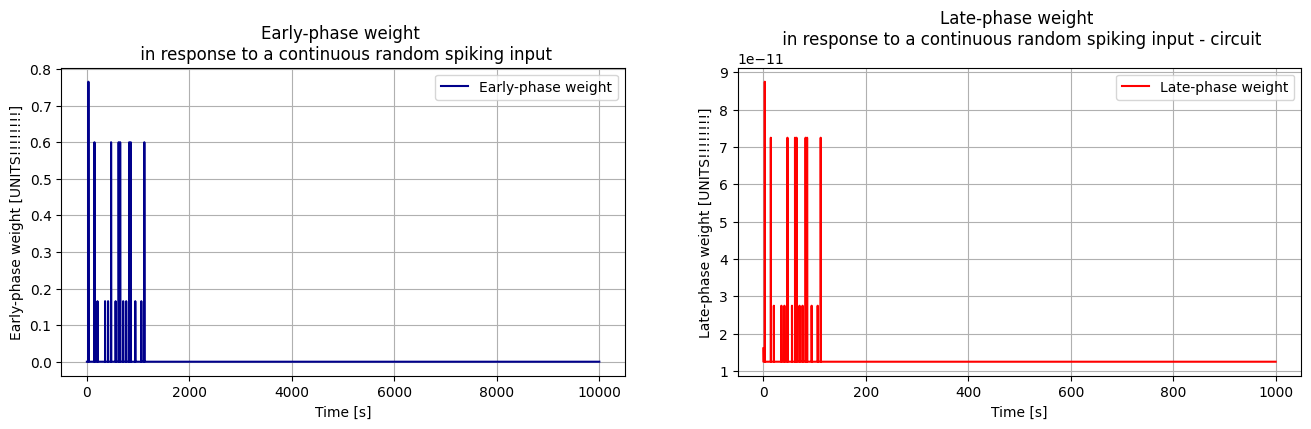

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 4))



# Plot first set of subplots
#axes[0].plot(t_eqx[9375:9425], c_ji_eqx[9375:9425], color='darkblue', label='Early-phase weight')
axes[0].plot(t_eqx, c_ji_eqx, color='darkblue', label='Early-phase weight')
axes[0].set_title("Early-phase weight \n in response to a continuous random spiking input")
axes[0].legend()
axes[0].grid()
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Early-phase weight [UNITS!!!!!!!!]")

#axes[1].plot(t_eqx_c[9375:9425], c_ji_eqx_c[9375:9425], color='red', label='Late-phase weight')
axes[1].plot(t_eqx_c, c_ji_eqx_c, color='red', label='Late-phase weight')
#axes[1].plot(t_eqx_c, c_ji_eqx_c, color='red', label='Late-phase weight')
axes[1].set_title("Late-phase weight \n in response to a continuous random spiking input - circuit")
axes[1].legend()
axes[1].grid()
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Late-phase weight [UNITS!!!!!!!!]")

plt.show()

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 4))



# Plot first set of subplots
#axes[0].plot(t_eqx[9375:9425], c_ji_eqx[9375:9425], color='darkblue', label='Early-phase weight')
# axes[0].plot(t_eqx[:120000], c_ji_eqx[:120000], color='darkblue', label='Early-phase weight')
axes[0].plot(t_eqx[:120000], h_ji_eqx[:120000]*100, color='darkblue', label='Early-phase weight')
axes[0].set_title("Early-phase weight \n in response to a continuous random spiking input")
axes[0].legend()
axes[0].grid()
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Early-phase weight [UNITS!!!!!!!!]")

#axes[1].plot(t_eqx_c[9375:9425], c_ji_eqx_c[9375:9425], color='red', label='Late-phase weight')
# axes[1].plot(t_eqx_c[:120000], c_ji_eqx_c[:120000], color='red', label='Late-phase weight')
axes[1].plot(t_eqx_c[:120000], h_ji_eqx_c[:120000]*1e-10, color='darkblue', label='Early-phase weight')
#axes[1].plot(t_eqx_c, c_ji_eqx_c, color='red', label='Late-phase weight')
axes[1].set_title("Late-phase weight \n in response to a continuous random spiking input - circuit")
axes[1].legend()
axes[1].grid()
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Late-phase weight [UNITS!!!!!!!!]")

plt.show()

In [ ]:
def calculate_percentage_change(array):
    first_value = array[0]
    if first_value == 0:
        # If the first value is zero, avoid division by zero by considering the change as zero
        percentage_change = jnp.zeros_like(array)
    else:
        percentage_change = (array - first_value) / first_value * 100
    return percentage_change

In [ ]:
# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Plot first set of subplots
#axes[0, 0].plot(t_eqx[:130000], h_ji_eqx[:130000], color='darkblue', label='Early-phase weight')
axes[0, 0].plot(t_eqx, calculate_percentage_change(h_ji_eqx)+100, color='forestgreen', label='Early-phase weight')
axes[0, 0].set_title("Synaptic weight changes \nas determined by the control script")
# axes[0, 0].set_title("Early-phase weight \n in response to a continuous random spiking input")
axes[0, 0].set_xticklabels([])
axes[0, 0].legend()
axes[0, 0].grid()
# axes[0, 0].set_xlabel("Time [s]")

axes[0, 0].set_ylabel("Early-phase weight [%]")

axes[1, 0].plot(t_eqx, calculate_percentage_change(z_ji_eqx)/10+100, color='royalblue', label='Late-phase weight')
# axes[1, 0].set_title("Late-phase weight \n in response to a continuous random spiking input")
axes[1, 0].legend()
axes[1, 0].grid()
# axes[1, 0].set_xlabel("Time [s]")
axes[1, 0].set_ylabel("Late-phase weight [%]")
axes[1, 0].set_xticklabels([])

# Plot third subplot
axes[2, 0].plot(t_eqx, calculate_percentage_change(w_ji_eqx)+100, color='darkorange', label='Late-phase weight')
# axes[2, 0].set_title("Total weight \n in response to a continuous random spiking input")
axes[2, 0].legend()
axes[2, 0].grid()
axes[2, 0].set_xlabel("Time [s]")
axes[2, 0].set_ylim(97, 205)
axes[2, 0].set_ylabel("Total synaptic weight [%]")


# Plot second set of subplots
#axes[0, 1].plot(t_eqx_c[:200000], h_ji_eqx_c[:200000], color='darkblue', label='Early-phase weight')
axes[0, 1].plot(t_eqx_c, calculate_percentage_change(h_ji_eqx_c)+100, color='forestgreen', label='Early-phase weight')
axes[0, 1].set_title("Synaptic weight changes \nas determined by the hardware script")
axes[0, 1].legend()
axes[0, 1].grid()
# axes[0, 1].set_xlabel("Time [s]")
# axes[0, 1].set_ylabel("Early-phase weight [UNITS!!!!!!!!]")
axes[0, 1].set_xticklabels([])

axes[1, 1].plot(t_eqx_c, calculate_percentage_change(z_ji_eqx_c)/10+100, color='royalblue', label='Late-phase weight')
# axes[1, 1].set_title("Late-phase weight \n in response to a continuous random spiking input")
axes[1, 1].legend()
axes[1, 1].grid()
# axes[1, 1].set_xlabel("Time [s]")
# axes[1, 1].set_ylabel("Late-phase weight [UNITS!!!!!!!!]")
axes[1, 1].set_xticklabels([])

# Plot third subplot
axes[2, 1].plot(t_eqx_c, calculate_percentage_change(w_ji_eqx_c)+100, color='darkorange', label='Late-phase weight')
# axes[2, 1].set_title("Total weight \n in response to a continuous random spiking input")
axes[2, 1].legend()
axes[2, 1].grid()
axes[2, 1].set_xlabel("Time [s]")
axes[2, 1].set_ylim(97, 205)
# axes[2, 1].set_ylabel("Total weight [UNITS!!!!!!!!]")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
# Show plot
plt.show()


In [ ]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot first set of subplots
#axes[0, 0].plot(t_eqx[:130000], h_ji_eqx[:130000], color='darkblue', label='Early-phase weight')
axes[0, 0].plot(t_eqx, calculate_percentage_change(h_ji_eqx)+100, color='forestgreen', label='Early-phase weight')
axes[0, 0].set_title("Synaptic weight changes \nas determined by the control script")
# axes[0, 0].set_title("Early-phase weight \n in response to a continuous random spiking input")
axes[0, 0].set_xticklabels([])
axes[0, 0].legend(loc = 'upper right')
# axes[0, 0].grid()
# axes[0, 0].set_xlabel("Time [s]")

axes[0, 0].set_ylabel("Early-phase weight [%]")

axes[0, 0].plot(t_eqx, calculate_percentage_change(z_ji_eqx)/10+100, color='royalblue', label='Late-phase weight')
# axes[1, 0].set_title("Late-phase weight \n in response to a continuous random spiking input")
axes[0, 0].legend(loc = 'upper right')
axes[0, 0].grid()
# axes[1, 0].set_xlabel("Time [s]")
axes[0, 0].set_ylabel("Late-phase weight [%]")
axes[0, 0].set_xticklabels([])

# Plot third subplot
axes[1, 0].plot(t_eqx, calculate_percentage_change(w_ji_eqx)+100, color='darkorange', label='Late-phase weight')
# axes[2, 0].set_title("Total weight \n in response to a continuous random spiking input")
axes[1, 0].legend(loc = 'upper right')
axes[1, 0].grid()
axes[1, 0].set_xlabel("Time [s]")
axes[1, 0].set_ylim(97, 205)
axes[1, 0].set_ylabel("Total synaptic weight [%]")


# Plot second set of subplots
#axes[0, 1].plot(t_eqx_c[:200000], h_ji_eqx_c[:200000], color='darkblue', label='Early-phase weight')
axes[0, 1].plot(t_eqx_c, calculate_percentage_change(h_ji_eqx_c)+100, color='forestgreen', label='Early-phase weight')
axes[0, 1].set_title("Synaptic weight changes \nas determined by the hardware script")
axes[0, 1].legend(loc = 'upper right')
# axes[0, 1].grid()
# axes[0, 1].set_xlabel("Time [s]")
# axes[0, 1].set_ylabel("Early-phase weight [UNITS!!!!!!!!]")
axes[0, 1].set_xticklabels([])

axes[0, 1].plot(t_eqx_c, calculate_percentage_change(z_ji_eqx_c)/10+100, color='royalblue', label='Late-phase weight')
# axes[1, 1].set_title("Late-phase weight \n in response to a continuous random spiking input")
axes[0, 1].legend(loc = 'upper right')
axes[0, 1].grid()
# axes[1, 1].set_xlabel("Time [s]")
# axes[1, 1].set_ylabel("Late-phase weight [UNITS!!!!!!!!]")
axes[0, 1].set_xticklabels([])

# Plot third subplot
axes[1, 1].plot(t_eqx_c, calculate_percentage_change(w_ji_eqx_c)+100, color='darkorange', label='Late-phase weight')
# axes[2, 1].set_title("Total weight \n in response to a continuous random spiking input")
axes[1, 1].legend(loc = 'upper right')
axes[1, 1].grid()
axes[1, 1].set_xlabel("Time [s]")
axes[1, 1].set_ylim(97, 205)
# axes[2, 1].set_ylabel("Total weight [UNITS!!!!!!!!]")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
# Show plot
plt.show()


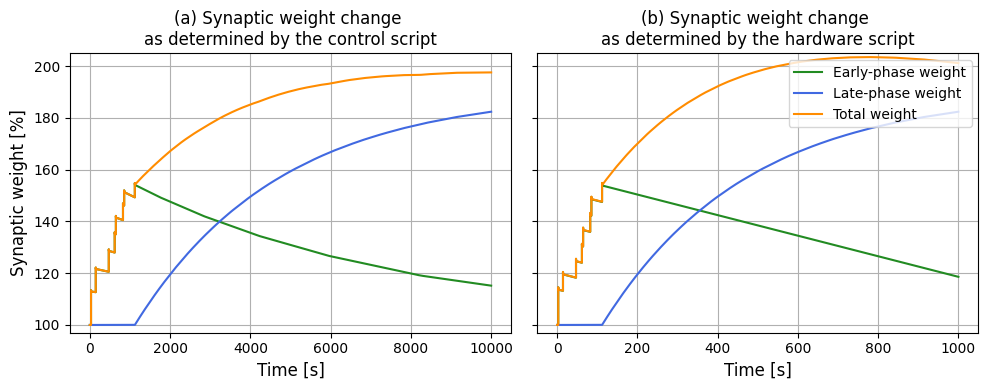

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot first set of subplots
#axes[0].plot(t_eqx[:130000], h_ji_eqx[:130000], color='darkblue', label='Early-phase weight')
axes[0].plot(t_eqx, calculate_percentage_change(h_ji_eqx)+100, color='forestgreen', label='Early-phase weight')
axes[0].set_title("(a) Synaptic weight change \nas determined by the control script")
# axes[0, 0].set_title("Early-phase weight \n in response to a continuous random spiking input")
# axes[0].set_xticklabels([])
# axes[0].legend(loc = 'upper right')
# axes[0, 0].grid()
# axes[0, 0].set_xlabel("Time [s]")

# axes[0].set_ylabel("Early-phase weight [%]")

axes[0].plot(t_eqx, calculate_percentage_change(z_ji_eqx)/10+100, color='royalblue', label='Late-phase weight')
# axes[1, 0].set_title("Late-phase weight \n in response to a continuous random spiking input")
# axes[0].legend(loc = 'upper right')
# axes[0].grid()
# axes[1, 0].set_xlabel("Time [s]")
# axes[0].set_ylabel("Late-phase weight [%]")
# axes[0].set_xticklabels([])

# Plot third subplot
axes[0].plot(t_eqx, calculate_percentage_change(w_ji_eqx-0.00042007)+100, color='darkorange', label='Total weight')
# axes[2, 0].set_title("Total weight \n in response to a continuous random spiking input")
# axes[0].legend(loc = 'upper right')
axes[0].grid()
axes[0].set_xlabel("Time [s]",  fontsize = 12)
axes[0].set_ylim(97, 205)
axes[0].set_ylabel("Synaptic weight [%]", fontsize = 12)


# Plot second set of subplots
#axes[0, 1].plot(t_eqx_c[:200000], h_ji_eqx_c[:200000], color='darkblue', label='Early-phase weight')
axes[1].plot(t_eqx_c, calculate_percentage_change(h_ji_eqx_c)+100, color='forestgreen', label='Early-phase weight')
axes[1].set_title("(b) Synaptic weight change \nas determined by the hardware script")
axes[1].legend(loc = 'upper right')
# axes[0, 1].grid()
# axes[0, 1].set_xlabel("Time [s]")
# axes[0, 1].set_ylabel("Early-phase weight [UNITS!!!!!!!!]")
# axes[1].set_xticklabels([])

axes[1].plot(t_eqx_c, calculate_percentage_change(z_ji_eqx_c)/10+100, color='royalblue', label='Late-phase weight')
# axes[1, 1].set_title("Late-phase weight \n in response to a continuous random spiking input")
axes[1].legend(loc = 'upper right')
# axes[1].grid()
# axes[1, 1].set_xlabel("Time [s]")
# axes[1, 1].set_ylabel("Late-phase weight [UNITS!!!!!!!!]")
# axes[1].set_xticklabels([])

# Plot third subplot
axes[1].plot(t_eqx_c, calculate_percentage_change(w_ji_eqx_c-0.00052007)+100, color='darkorange', label='Total weight')
# axes[2, 1].set_title("Total weight \n in response to a continuous random spiking input")
axes[1].legend(loc = 'upper right')
axes[1].grid()
axes[1].set_xlabel("Time [s]",  fontsize = 12)
axes[1].set_ylim(97, 205)
axes[1].set_yticklabels([])
# axes[2, 1].set_ylabel("Total weight [UNITS!!!!!!!!]")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
# Show plot
plt.show()


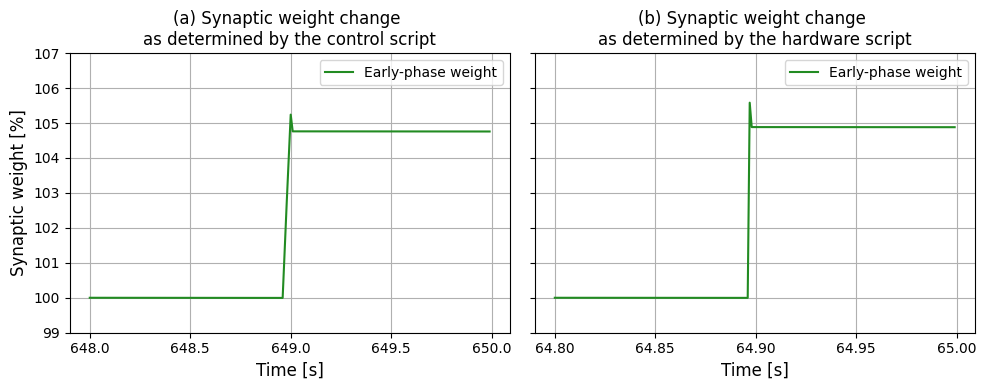

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# # Plot first set of subplots
#axes[0].plot(t_eqx[:130000], h_ji_eqx[:130000], color='darkblue', label='Early-phase weight')
axes[0].plot(t_eqx[64800:65000], calculate_percentage_change(h_ji_eqx[64800:65000])+100, color='forestgreen', label='Early-phase weight')
axes[0].set_title("(a) Synaptic weight change \nas determined by the control script")
# axes[0, 0].set_title("Early-phase weight \n in response to a continuous random spiking input")
axes[0].set_xticks([648.0, 648.5, 649., 649.5, 650.0])
axes[0].legend(loc = 'upper right')
axes[0].grid()
axes[0].set_xlabel("Time [s]", fontsize = 12)

axes[0].set_ylim(99, 107)
# # axes[0].set_ylabel("Early-phase weight [%]")

# axes[0].plot(t_eqx, calculate_percentage_change(z_ji_eqx)/10+100, color='royalblue', label='Late-phase weight')
# # axes[1, 0].set_title("Late-phase weight \n in response to a continuous random spiking input")
# # axes[0].legend(loc = 'upper right')
# # axes[0].grid()
# # axes[1, 0].set_xlabel("Time [s]")
# # axes[0].set_ylabel("Late-phase weight [%]")
# # axes[0].set_xticklabels([])

# # Plot third subplot
# axes[0].plot(t_eqx, calculate_percentage_change(w_ji_eqx-0.00042007)+100, color='darkorange', label='Total weight')
# # axes[2, 0].set_title("Total weight \n in response to a continuous random spiking input")
# # axes[0].legend(loc = 'upper right')
# axes[0].grid()
# axes[0].set_xlabel("Time [s]",  fontsize = 12)
# axes[0].set_ylim(97, 205)
axes[0].set_ylabel("Synaptic weight [%]", fontsize = 12)


# # Plot second set of subplots
# #axes[0, 1].plot(t_eqx_c[:200000], h_ji_eqx_c[:200000], color='darkblue', label='Early-phase weight')
axes[1].plot(t_eqx_c[64800:65000], calculate_percentage_change(h_ji_eqx_c[64800:65000])+100, color='forestgreen', label='Early-phase weight')
axes[1].set_title("(b) Synaptic weight change \nas determined by the hardware script")
# axes[1].legend(loc = 'upper right')
# # axes[0, 1].grid()
# # axes[0, 1].set_xlabel("Time [s]")
# # axes[0, 1].set_ylabel("Early-phase weight [UNITS!!!!!!!!]")
# # axes[1].set_xticklabels([])

# axes[1].plot(t_eqx_c, calculate_percentage_change(z_ji_eqx_c)/10+100, color='royalblue', label='Late-phase weight')
# # axes[1, 1].set_title("Late-phase weight \n in response to a continuous random spiking input")
# axes[1].legend(loc = 'upper right')
# # axes[1].grid()
# # axes[1, 1].set_xlabel("Time [s]")
# # axes[1, 1].set_ylabel("Late-phase weight [UNITS!!!!!!!!]")
# # axes[1].set_xticklabels([])

# Plot third subplot
# axes[1].plot(t_eqx_c[64800:65000], calculate_percentage_change(w_ji_eqx_c[64800:65000]-0.00052007)+100, color='darkorange', label='Total weight')
# axes[2, 1].set_title("Total weight \n in response to a continuous random spiking input")
axes[1].legend(loc = 'upper right')
axes[1].grid()
axes[1].set_xlabel("Time [s]",  fontsize = 12)
axes[1].set_ylim(99, 107)
axes[1].set_yticklabels([])
axes[1].set_xticks([64.80, 64.85, 64.9, 64.95, 65.00])
# axes[2, 1].set_ylabel("Total weight [UNITS!!!!!!!!]")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
# Show plot
plt.show()


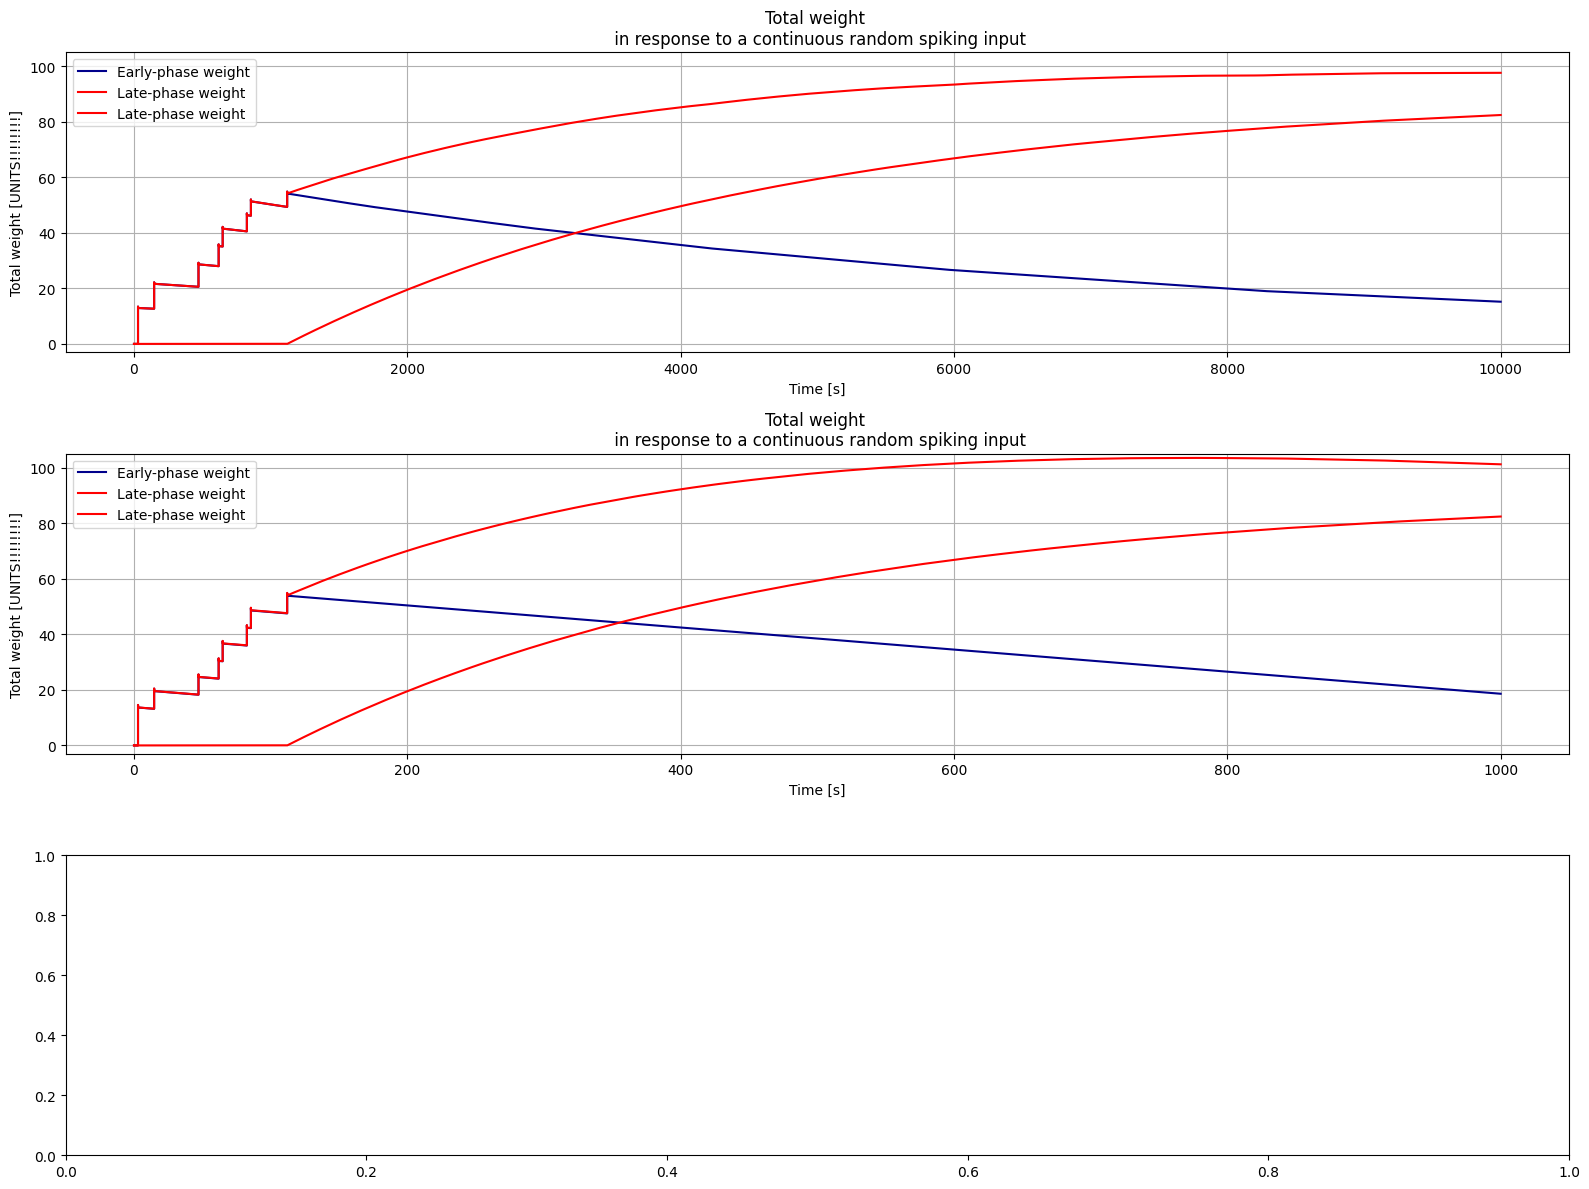

In [ ]:
# # Create subplots
# fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# # Plot first set of subplots
# #axes[0, 0].plot(t_eqx[:130000], h_ji_eqx[:130000], color='darkblue', label='Early-phase weight')
# axes[0].plot(t_eqx, calculate_percentage_change(h_ji_eqx), color='darkblue', label='Early-phase weight')
# axes[0].set_title("Early-phase weight \n in response to a continuous random spiking input")
# axes[0].legend()
# axes[0].grid()
# axes[0].set_xlabel("Time [s]")
# axes[0].set_ylabel("Early-phase weight [UNITS!!!!!!!!]")

# axes[0].plot(t_eqx, calculate_percentage_change(z_ji_eqx)/10, color='red', label='Late-phase weight')
# axes[0].set_title("Late-phase weight \n in response to a continuous random spiking input")
# axes[0].legend()
# axes[0].grid()
# axes[0].set_xlabel("Time [s]")
# axes[0].set_ylabel("Late-phase weight [UNITS!!!!!!!!]")

# # Plot third subplot
# axes[0].plot(t_eqx, calculate_percentage_change(w_ji_eqx-0.00042007), color='red', label='Late-phase weight')
# axes[0].set_title("Total weight \n in response to a continuous random spiking input")
# axes[0].legend()
# axes[0].grid()
# axes[0].set_xlabel("Time [s]")
# axes[0].set_ylim(-3, 105)
# axes[0].set_ylabel("Total weight [UNITS!!!!!!!!]")

# # Plot second set of subplots
# #axes[0, 1].plot(t_eqx_c[:200000], h_ji_eqx_c[:200000], color='darkblue', label='Early-phase weight')
# axes[1].plot(t_eqx_c, calculate_percentage_change(h_ji_eqx_c), color='darkblue', label='Early-phase weight')
# axes[1].set_title("Early-phase weight \n in response to a continuous random spiking input - circuit")
# axes[1].legend()
# axes[1].grid()
# axes[1].set_xlabel("Time [s]")
# axes[1].set_ylabel("Early-phase weight [UNITS!!!!!!!!]")

# axes[1].plot(t_eqx_c, calculate_percentage_change(z_ji_eqx_c)/10, color='red', label='Late-phase weight')
# axes[1].set_title("Late-phase weight \n in response to a continuous random spiking input")
# axes[1].legend()
# axes[1].grid()
# axes[1].set_xlabel("Time [s]")
# axes[1].set_ylabel("Late-phase weight [UNITS!!!!!!!!]")
# # Plot third subplot
# axes[1].plot(t_eqx_c, calculate_percentage_change(w_ji_eqx_c-0.00052007), color='red', label='Late-phase weight')
# axes[1].set_title("Total weight \n in response to a continuous random spiking input")
# axes[1].legend()
# axes[1].grid()
# axes[1].set_xlabel("Time [s]")
# axes[1].set_ylim(-3, 105)
# axes[1].set_ylabel("Total weight [UNITS!!!!!!!!]")

# # Adjust layout
# plt.tight_layout()

# # Show plot
# plt.show()


In [ ]:
# print(h_ji_eqx[100]-w_ji_eqx[100])

# print(h_ji_eqx[10000])
# print(w_ji_eqx[10000])

print(h_ji_eqx_c[100]-w_ji_eqx_c[100])

# print(h_ji_eqx[10000])
# print(w_ji_eqx[10000])


# Scrap

In [ ]:
# plt.plot(t_eqx, h_ji_eqx)
plt.plot(t_eqx, h_ji_eqx_c)

# **2 neurons, 1 synapse**

## **Implementation of neuron**

In [ ]:
# # Neuron with single input synapse

# class neuron_behaviour(eqx.Module):
#     Vi_0: float
#     w_ji_0: float
#     ica_0: float
#     v_h0: float
#     v_H0: float
#     z_0: float
#     tau_m: float
#     V_rev: float
#     R_m: float
#     dt: float
#     tau_DPI: float
#     I_TH: float
#     I_INDC: float
#     I_TAU: float
#     delta_capre: float
#     delta_capost: float
#     I_THPOT: float
#     I_THDEP: float
#     i_hrn: float
#     i_hrp: float
#     I_TAILP: float
#     I_TAILP_low: float
#     I_TAILD: float
#     I_TAILD_low: float
#     C: float
#     theta_pro_circuit: float
#     alpha: float
#     z_max: float
#     z_min: float
#     theta_tag_c: float
#     tau_z_c: float
#     beta: float

#     def __init__(self, Vi_0, w_ji_0, ica_0, v_h0, v_H0, z_0, tau_m, V_rev, R_m, dt, tau_DPI, I_TH, I_INDC, I_TAU, delta_capre, delta_capost, I_THPOT, I_THDEP, i_hrn, i_hrp, I_TAILP, I_TAILP_low, I_TAILD, I_TAILD_low, C, theta_pro_circuit, alpha, z_max, z_min, theta_tag_c, tau_z_c, beta):
#         self.Vi_0 = Vi_0
#         self.w_ji_0 = w_ji_0
#         self.ica_0 = ica_0
#         self.v_h0 = v_h0
#         self.v_H0 = v_H0
#         self.z_0 = z_0
#         self.tau_m = tau_m
#         self.V_rev = V_rev
#         self.R_m = R_m
#         self.dt = dt
#         self.tau_DPI = tau_DPI
#         self.I_TH = I_TH
#         self.I_INDC = I_INDC
#         self.I_TAU = I_TAU
#         self.delta_capre = delta_capre
#         self.delta_capost = delta_capost
#         self.I_THPOT = I_THPOT
#         self.I_THDEP = I_THDEP
#         self.i_hrn = i_hrn
#         self.i_hrp = i_hrp
#         self.I_TAILP = I_TAILP
#         self.I_TAILP_low = I_TAILP_low
#         self.I_TAILD = I_TAILD
#         self.I_TAILD_low = I_TAILD_low
#         self.C = C
#         self.theta_pro_circuit = theta_pro_circuit
#         self.alpha = alpha
#         self.z_max = z_max
#         self.z_min = z_min
#         self.theta_tag_c = theta_tag_c
#         self.tau_z_c = tau_z_c
#         self.beta = beta


#     def __call__(self, input_):

#         V_i_0 = jnp.zeros((1,)) + self.Vi_0  # Initial state
#         w_ji_0 = jnp.zeros((1,)) + self.w_ji_0
#         i_ca_0 = jnp.zeros((1,)) + self.ica_0
#         v_h_0 = jnp.zeros((1,)) + self.v_h0
#         z_ji_0 = jnp.zeros((1,)) + self.z_0
#         p_i = 0.0
#         w_ji_0 = jnp.zeros((1,))

#         def second_layer_neuron_and_synapse(carry, input_):

#             # Code for the neuron:..............................................
#             t_spike_pre, t_spike_post, I_stim = input_
#             V_i, i_ca, v_h, z_ji,_p_i, w_ji = carry

#             reversal_term = (1 / self.tau_m) * (-V_i + self.V_rev)
#             pre_spike_contribution = (1 / self.tau_m) * (t_spike_pre * w_ji)  # This is where you would also need to sum over all the synapses
#             current_term = (1 / self.tau_m) * (self.R_m * I_stim)

#             V_i_new = V_i + (reversal_term + current_term) * self.dt + pre_spike_contribution

#             # Code to update the weight of the synapse: ........................
#             # Calcium part: ----------------------------------------------------
#             dica_dt = (1 / self.tau_DPI) * (-i_ca + self.I_TH * self.I_INDC / self.I_TAU)
#             ica_pre_increase = t_spike_pre * self.delta_capre
#             ica_post_increase = t_spike_post * self.delta_capost

#             i_ca_new = i_ca + dica_dt * self.dt + ica_pre_increase + ica_post_increase

#             # Early-phase part: ------------------------------------------------
#             recovery_condition = jnp.squeeze(v_h > self.v_H0)
#             potentiation_condition = jnp.squeeze(i_ca > self.I_THPOT)
#             depression_condition = jnp.squeeze(i_ca > self.I_THDEP)

#             i_recovery = jax.lax.cond(recovery_condition, lambda _: - self.i_hrn, lambda _: self.i_hrp, operand=None)
#             i_potentiation = jax.lax.cond(potentiation_condition, lambda _: self.I_TAILP, lambda _: self.I_TAILP_low, operand=None)
#             i_depression = jax.lax.cond(depression_condition, lambda _: - self.I_TAILD, lambda _: self.I_TAILD_low, operand=None)

#             v_h_new = v_h + (1 / self.C) * (i_recovery + i_potentiation + i_depression) * self.dt

#             # Late-phase part: -------------------------------------------------

#             # Early-phase change of neuron i
#             epsilon_hi = jnp.abs(v_h - self.v_h0)

#             # Check if the early-phase change is sufficient to trigger protein synthesis:
#             condition = jnp.squeeze(epsilon_hi > self.theta_pro_circuit)
#             p_i = jax.lax.cond(condition, lambda _: self.alpha, lambda _: p_i, operand=None)


#             # Calculate the change in late-phase variable based on the differential equation.

#             # Potentiation contribution
#             pot_term = p_i * (self.z_max - z_ji) * ((v_h - self.v_h0 - self.theta_tag_c) > 0)

#             # Depression contribution
#             dep_term = p_i * (z_ji - self.z_min) * ((self.h_0 - v_h - self.theta_tag_c) > 0)

#             # Combine terms to get the total change
#             dz_dt = (1 / self.tau_z_c) * (pot_term - dep_term)

#             # Update late-phase variable using Euler's method
#             z_ji_new = z_ji + dz_dt * self.dt

#             # Calculating total synaptic weight --------------------------------
#             w_ji_new = self.beta * v_h + self.beta * self.v_h0 * z_ji

#             return (V_i_new, i_ca_new, v_h_new, z_ji_new, p_i, w_ji_new), V_i_new

#         initial_conditions = (V_i_0, i_ca_0, v_h_0, z_ji_0, p_i, w_ji_0)

#         _, V_i = jax.lax.scan(second_layer_neuron_and_synapse, initial_conditions, input_)
#         time_array = jnp.arange(len(V_i)) * self.dt

#         return V_i, time_array

# Vi_0 = 0
# w_ji_0 = 0
# tau_m = 1
# V_rev = 1
# R_m = 1


# synapse_neuron = neuron_behaviour(Vi_0, w_ji_0, ica_0, v_h0, v_H0, z_0, tau_m, V_rev, R_m, dt, tau_DPI, I_TH, I_INDC, I_TAU, delta_capre, delta_capost, I_THPOT, I_THDEP, i_hrn, i_hrp, I_TAILP, I_TAILP_low, I_TAILD, I_TAILD_low, C, theta_pro_circuit, alpha, z_max, z_min, theta_tag_c, tau_z_c, beta)

# v_i_eqz, tarrayeqz = synapse_neuron(((jnp.array(t_spike_pre_new), jnp.array(t_spike_post_new)), jnp.array(t_spike_post_new)))



In [ ]:
# Vi_0 = 0
# w_ji_0 = 0
# tau_m = 1
# V_rev = 1
# R_m = 1


# synapse_neuron = neuron_behaviour(Vi_0, w_ji_0, ica_0, v_h0, v_H0, z_0, tau_m, V_rev, R_m, dt, tau_DPI, I_TH, I_INDC, I_TAU, delta_capre, delta_capost, I_THPOT, I_THDEP, i_hrn, i_hrp, I_TAILP, I_TAILP_low, I_TAILD, I_TAILD_low, C, theta_pro_circuit, alpha, z_max, z_min, theta_tag_c, tau_z_c, beta)

# v_i_eqz, tarrayeqz = synapse_neuron(((jnp.array(t_spike_pre_new), jnp.array(t_spike_post_new)), jnp.array(t_spike_post_new)))

In [ ]:
pre_spikes =  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] #generate_binary_array(length, ratio, key)

post_spikes = [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] #generate_binary_array(length, ratio, key)





In [ ]:
import jax
import jax.numpy as jnp
import equinox as eqx

class full_synapse_ciruit3(eqx.Module):
    tau_DPI: float
    dt: float
    delta_capre: float
    delta_capost: float
    I_TH: float
    I_INDC: float
    I_TAU: float
    ica_0: float
    C: float
    v_H0: float
    I_THPOT: float
    I_THDEP: float
    I_TAILP: float
    I_TAILP_low: float
    I_TAILD: float
    I_TAILD_low: float
    i_hrn: float
    i_hrp: float
    v_h0: float
    V_DD: float
    tau_z_c: float
    z_max: float
    z_min: float
    theta_tag_c: float
    alpha: float
    theta_pro_circuit: float
    z_0: float
    beta: float
    reset_voltage: float
    V_rev: float
    V_spike_threshold: float
    tau_m: float
    R_m: float
    h_0: float = 0.0

    def __call__(self, input_):
        # Initial states
        i_ca = jnp.zeros((1,)) + self.ica_0
        v_h = jnp.zeros((1,)) + self.v_h0
        z_ji = jnp.zeros((1,)) + self.z_0
        w_ji = jnp.zeros((1,))
        V_i = jnp.zeros((1,))
        p_i = 0.0
        t_spike_post = 0.0  # Initialize t_spike_post to 0

        # Lists to store the results
        i_ca_list = []
        v_h_list = []
        z_ji_list = []
        w_ji_list = []
        V_i_list = []
        t_spike_post_list = []

        def step(carry, input_):
            t_spike_post, i_ca, v_h, z_ji, p_i, w_ji, V_i = carry
            t_spike_pre, I_stim = input_

            # Code for the neurons in the second layer:..............................
            reversal_term = (1 / self.tau_m) * (-V_i + self.V_rev)
            pre_spike_contribution = (1 / self.tau_m) * (t_spike_pre * w_ji)
            current_term = (1 / self.tau_m) * (self.R_m * I_stim)

            spike_condition = jnp.squeeze(V_i > self.V_spike_threshold)

            V_i_new = jax.lax.cond(spike_condition, lambda _: jnp.array([self.reset_voltage]), lambda _: V_i + (reversal_term + current_term) * self.dt + pre_spike_contribution, operand=None)

            # Update t_spike_post based on spike condition
            t_spike_post_new = jax.lax.cond(spike_condition, lambda _: 1.0, lambda _: 0.0, operand=None)
            t_spike_post_list.append(t_spike_post_new)

            # Calcium part ---------------------------------------------------------
            dica_dt = (1 / self.tau_DPI) * (-i_ca + self.I_TH * self.I_INDC / self.I_TAU)
            ica_pre_increase = t_spike_pre * self.delta_capre
            ica_post_increase = t_spike_post_new * self.delta_capost
            i_ca_new = i_ca + dica_dt * self.dt + ica_pre_increase + ica_post_increase

            # Early-phase part -----------------------------------------------------
            recovery_condition = jnp.squeeze(v_h > self.v_H0)
            potentiation_condition = jnp.squeeze(i_ca_new > self.I_THPOT)
            depression_condition = jnp.squeeze(i_ca_new > self.I_THDEP)
            i_recovery = jax.lax.cond(recovery_condition, lambda _: - self.i_hrn, lambda _: self.i_hrp, operand=None)
            i_potentiation = jax.lax.cond(potentiation_condition, lambda _: self.I_TAILP, lambda _: self.I_TAILP_low, operand=None)
            i_depression = jax.lax.cond(depression_condition, lambda _: - self.I_TAILD, lambda _: self.I_TAILD_low, operand=None)
            v_h_new = v_h + (1 / self.C) * (i_recovery + i_potentiation + i_depression) * self.dt

            # Late-phase part ------------------------------------------------------
            epsilon_hi = jnp.abs(v_h_new - self.v_h0)
            condition = jnp.squeeze(epsilon_hi > self.theta_pro_circuit)
            p_i = jax.lax.cond(condition, lambda _: self.alpha, lambda _: p_i, operand=None)
            pot_term = p_i * (self.z_max - z_ji) * ((v_h_new - self.v_h0 - self.theta_tag_c) > 0)
            dep_term = p_i * (z_ji - self.z_min) * ((self.h_0 - v_h_new - self.theta_tag_c) > 0)
            dz_dt = (1 / self.tau_z_c) * (pot_term - dep_term)
            z_ji_new = z_ji + dz_dt * self.dt

            # Total synaptic weight ------------------------------------------------
            w_ji_new = self.beta * v_h_new + self.beta * self.v_h0 * z_ji_new

            # Store results
            i_ca_list.append(i_ca_new)
            v_h_list.append(v_h_new)
            z_ji_list.append(z_ji_new)
            w_ji_list.append(w_ji_new)
            V_i_list.append(V_i_new)


            carry = (t_spike_post_new, i_ca_new, v_h_new, z_ji_new, p_i, w_ji_new, V_i_new)
            return carry, (i_ca_new, v_h_new, z_ji_new, w_ji_new, V_i_new, t_spike_post_new)

        carry = (t_spike_post, i_ca, v_h, z_ji, p_i, w_ji, V_i)
        _, (i_ca, v_h, z_ji, w_ji, V_i, t_spike_post) = jax.lax.scan(step, carry, input_)

        time_array = jnp.arange(len(i_ca)) * self.dt

        return i_ca, v_h, z_ji, w_ji, V_i, t_spike_post, time_array


# Defining more constants:
tau_m = 1.0
V_rev = 1.0
R_m = 1.0
reset_voltage = 0.0
V_spike_threshold = 0.01000

synapseCircuit3 = full_synapse_ciruit3(
    tau_DPI, dt_c, delta_capre, delta_capost, I_TH, I_INDC, I_TAU, ica_0,
    C, v_H0, I_THPOT, I_THDEP, I_TAILP, I_TAILP_low, I_TAILD, I_TAILD_low, i_hrn, i_hrp,
    v_h0, V_DD, tau_z_c, z_max, z_min, theta_tag_c, alpha, theta_pro_circuit, z_0, beta, reset_voltage, V_rev, V_spike_threshold, tau_m, R_m
)

in_spikes = [0,1,0,1,0,0,1]
in_I =      [0,0,0,0,0,0,0]

c_ji_eqx_c2, h_ji_eqx_c2, z_ji_eqx_c2, w_ji_eqx_c2, V_III, t_spiike_post, t_eqx_c2 = synapseCircuit3((jnp.array(in_spikes), jnp.array(in_I)))

synapseCircuitq = full_synapse_ciruit(
    tau_DPI, dt_c, delta_capre, delta_capost, I_TH, I_INDC, I_TAU, ica_0,
    C, v_H0, I_THPOT, I_THDEP, I_TAILP, I_TAILP_low, I_TAILD, I_TAILD_low, i_hrn, i_hrp,
    v_h0, V_DD, tau_z_c, z_max, z_min, theta_tag_c, alpha, theta_pro_circuit, z_0, beta
)

c_ji_eqx_cq, h_ji_eqx_cq, z_ji_eqx_cq, w_ji_eqx_cq, t_eqx_cq = synapseCircuitq((jnp.array(in_spikes), jnp.array(t_spiike_post)))

print(c_ji_eqx_cq)



In [ ]:
plt.plot(t_eqx_c2, c_ji_eqx_c2)
plt.show()

plt.plot(t_eqx_c2, V_III)
plt.show()

plt.plot(t_eqx_c2, z_ji_eqx_c2)
plt.show()


plt.plot(t_eqx_c2, w_ji_eqx_c2)
plt.show()


plt.plot(t_eqx_c2, w_ji_eqx_c2)
print(t_spiike_post)


# plot these next to the ones on top

plt.plot(t_eqx_cq, c_ji_eqx_cq)
plt.show()

plt.plot(t_eqx_cq, h_ji_eqx_cq)
plt.show()

plt.plot(t_eqx_cq, z_ji_eqx_cq)
plt.show()


plt.plot(t_eqx_cq, w_ji_eqx_cq)
plt.show()


plt.plot(t_eqx_cq, w_ji_eqx_cq)
print(t_spiike_post)



In [ ]:
c_ji_eqx_cw, h_ji_eqx_cw, z_ji_eqx_cw, w_ji_eqx_cw, t_eqx_cw = synapseCircuit((jnp.array([0,1,0,1,0,0,1]), jnp.array([0,0,0,0,1,0,0])))

plt.plot(t_eqx_cw, c_ji_eqx_cw)



In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

# First column
axs[0, 0].plot(t_eqx_c2, c_ji_eqx_c2)
axs[0, 0].set_title('c_ji_eqx_c2')

axs[1, 0].plot(t_eqx_c2, w_ji_eqx_c2)
axs[1, 0].set_title('w_ji_eqx_c2')

axs[2, 0].plot(t_eqx_c2, z_ji_eqx_c2)
axs[2, 0].set_title('z_ji_eqx_c2')

axs[3, 0].plot(t_eqx_c2, w_ji_eqx_c2)
axs[3, 0].set_title('w_ji_eqx_c2')

axs[4, 0].plot(t_eqx_c2, w_ji_eqx_c2)
axs[4, 0].set_title('w_ji_eqx_c2')

# Second column
axs[0, 1].plot(t_eqx_cq, c_ji_eqx_cq)
axs[0, 1].set_title('c_ji_eqx_cq')

axs[1, 1].plot(t_eqx_cq, h_ji_eqx_cq)
axs[1, 1].set_title('h_ji_eqx_cq')

axs[2, 1].plot(t_eqx_cq, z_ji_eqx_cq)
axs[2, 1].set_title('z_ji_eqx_cq')

axs[3, 1].plot(t_eqx_cq, w_ji_eqx_cq)
axs[3, 1].set_title('w_ji_eqx_cq')

axs[4, 1].plot(t_eqx_cq, w_ji_eqx_cq)
axs[4, 1].set_title('w_ji_eqx_cq')

plt.tight_layout()
plt.show()

In [ ]:
# Defining more constants:
tau_m = 1.0
V_rev = 1.0
R_m = 1.0
reset_voltage = 0.0
V_spike_threshold = 3.0

In [ ]:
# Chat gpt nice and functional

import jax
import jax.numpy as jnp
import equinox as eqx

class full_synapse_ciruit2(eqx.Module):
    tau_DPI: float
    dt: float
    delta_capre: float
    delta_capost: float
    I_TH: float
    I_INDC: float
    I_TAU: float
    ica_0: float
    C: float
    v_H0: float
    I_THPOT: float
    I_THDEP: float
    I_TAILP: float
    I_TAILP_low: float
    I_TAILD: float
    I_TAILD_low: float
    i_hrn: float
    i_hrp: float
    v_h0: float
    V_DD: float
    tau_z_c: float
    z_max: float
    z_min: float
    theta_tag_c: float
    alpha: float
    theta_pro_circuit: float
    z_0: float
    beta: float
    h_0: float = 0.0

    def __call__(self, input_):
        # Initial states
        i_ca = jnp.zeros((1,)) + self.ica_0
        v_h = jnp.zeros((1,)) + self.v_h0
        w_ji = jnp.zeros((num_synapses,)) + self.beta * self.v_h0 + self.beta * self.v_h0 * self.z_0
        V_i = jnp.zeros((1,)) + self.V_rev
        p_i = 0.0

        # Lists to store the results
        i_ca_list = []
        v_h_list = []
        z_ji_list = []
        w_ji_list = []

        def step(carry, input_):
            i_ca, v_h, z_ji, p_i, w_ji = carry
            t_spike_pre, t_spike_post = input_

            # Calcium part ---------------------------------------------------------
            dica_dt = (1 / self.tau_DPI) * (-i_ca + self.I_TH * self.I_INDC / self.I_TAU)
            ica_pre_increase = t_spike_pre * self.delta_capre
            ica_post_increase = t_spike_post * self.delta_capost
            i_ca_new = i_ca + dica_dt * self.dt + ica_pre_increase + ica_post_increase

            # Early-phase part -----------------------------------------------------
            recovery_condition = jnp.squeeze(v_h > self.v_H0)
            potentiation_condition = jnp.squeeze(i_ca > self.I_THPOT)
            depression_condition = jnp.squeeze(i_ca > self.I_THDEP)
            i_recovery = jax.lax.cond(recovery_condition, lambda _: - self.i_hrn, lambda _: self.i_hrp, operand=None)
            i_potentiation = jax.lax.cond(potentiation_condition, lambda _: self.I_TAILP, lambda _: self.I_TAILP_low, operand=None)
            i_depression = jax.lax.cond(depression_condition, lambda _: - self.I_TAILD, lambda _: self.I_TAILD_low, operand=None)
            v_h_new = v_h + (1 / self.C) * (i_recovery + i_potentiation + i_depression) * self.dt

            # Late-phase part ------------------------------------------------------
            epsilon_hi = jnp.abs(v_h_new - self.v_h0)
            condition = jnp.squeeze(epsilon_hi > self.theta_pro_circuit)
            p_i = jax.lax.cond(condition, lambda _: self.alpha, lambda _: p_i, operand=None)
            pot_term = p_i * (self.z_max - z_ji) * ((v_h_new - self.v_h0 - self.theta_tag_c) > 0)
            dep_term = p_i * (z_ji - self.z_min) * ((self.h_0 - v_h_new - self.theta_tag_c) > 0)
            dz_dt = (1 / self.tau_z_c) * (pot_term - dep_term)
            z_ji_new = z_ji + dz_dt * self.dt

            # Total synaptic weight ------------------------------------------------
            w_ji_new = self.beta * v_h_new + self.beta * self.v_h0 * z_ji_new

            # Store results
            i_ca_list.append(i_ca_new)
            v_h_list.append(v_h_new)
            z_ji_list.append(z_ji_new)
            w_ji_list.append(w_ji_new)

            carry = (i_ca_new, v_h_new, z_ji_new, p_i, w_ji_new)
            return carry, (i_ca_new, v_h_new, z_ji_new, w_ji_new)

        carry = (i_ca, v_h, z_ji, p_i, w_ji)
        _, (i_ca, v_h, z_ji, w_ji) = jax.lax.scan(step, carry, input_)

        time_array = jnp.arange(len(i_ca)) * self.dt

        return i_ca, v_h, z_ji, w_ji, time_array
